# [OpenCV-Python Tutorial] Classification

In this notebook, we will learn how to perform Object Classification using Visual Bag of Words(VBoW), spatial histogram feature, and SVM classifier.

---

In [ ]:
# SIFT dependency
!pip uninstall --yes opencv-python
!pip uninstall --yes opencv-contrib-python
!pip install opencv-python==3.3.0.10
!pip install opencv-contrib-python==3.3.0.10

In [1]:
# download images
import requests
import os

os.makedirs('./images', exist_ok=True)
def download_file(url):
    filename = url.split('/')[-1].split('?')[0]
    r = requests.get(url, allow_redirects=True)
    open(f'./images/{filename}', 'wb').write(r.content)

url = "https://github.com/skaro94/iab_practice_example/blob/master/images/"
postfix = "?raw=true"
download_file(url + "dragonfly.png" + postfix)

In [2]:
import os, sys
import tarfile
import time
import random
import pickle
from glob import glob

import wget
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
caltech_url = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
caltech_filename = '101_ObjectCategories.tar.gz'
caltech_dir = '101_ObjectCategories/'

numTrain = 15
numTest = 15
numClasses = 102
numWords = 600

vocabPath = 'vocab.pkl'
bestLabelsPath = 'bestLabels.pkl'
svmPath = os.path.join(caltech_dir, 'svm_data.dat')

# Dataset

## 1. Download Caltech-101 dataset

In [4]:
if not os.path.exists(caltech_dir) or not os.path.exists(os.path.join(caltech_dir, 'airplanes')):
    print('Downloading Caltech-101')
    if not os.path.exists(caltech_filename) or os.path.getsize(caltech_filename) != 131740031:
        wget.download(caltech_url)
    print('Extracting Caltech-101')
    with tarfile.open(caltech_filename) as tar:
        tar.extractall()

print('Caltech-101 dataset checked')

Caltech-101 dataset checked


## 2. Setup Data

# Dense SIFT(PHOW) and Visual Words

Select 15 train/test images for each class
done


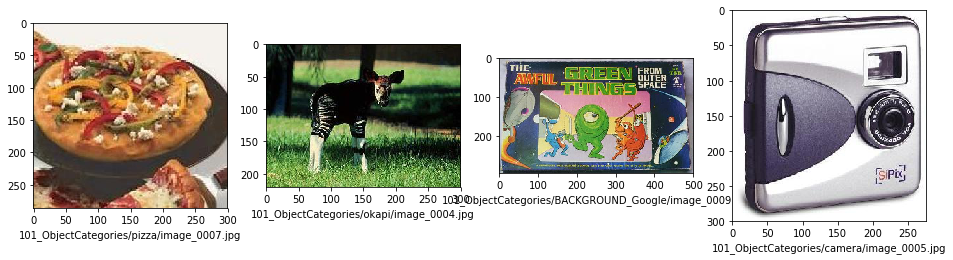

In [5]:
# Select 15 train/test images for each class
print('Select 15 train/test images for each class')
classes = next(os.walk(caltech_dir))[1]
train_image_ll = []
test_image_ll = []
for c in classes:
    class_dir = os.path.join(caltech_dir, c, '*.jpg')
    ims = glob(class_dir)
    ims.sort()
    train_image_ll.append([f for f in ims[:numTrain]])
    test_image_ll.append([f for f in ims[numTrain:numTrain+numTest]])
print('done')

# Show 4 random images
plt.figure(figsize=(16,4))
for i, idx in enumerate(random.sample(range(len(classes)), 4)):
    fpath = random.sample(train_image_ll[idx], 1)[0]
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel(fpath)

## 1. SIFT helper functions

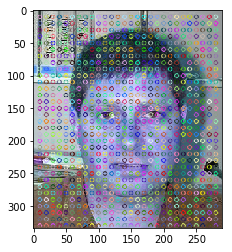

In [6]:
sift = cv2.xfeatures2d.SIFT_create()

# Resize a image if it's too large
def standarizeImage(img):
    rows, cols = img.shape
    if cols > 480:
        img = cv2.resize(img, (480, int(rows*480/cols)))
    return img

# Detect and extract SIFT from a single image
def SIFT(img):
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

# Load an image + Resize if large + Extract SIFT
def SIFT2(img_fpath):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return SIFT(img)

# Dense SIFT(Extract SIFT descriptor in grid points over an image)
def denseSIFT(img, step = 10, size = 7):
    rows, cols = img.shape[:2]
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    return kp, des

# Load an image + Resize if large + Dense SIFT
def denseSIFT2(img_fpath, step = 10):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return denseSIFT(img, step)

# Dense SIFT
tmp_im = cv2.cvtColor(cv2.imread(train_image_ll[0][0]), cv2.COLOR_BGR2RGB)
#kp, des = SIFT(tmp_im)
kp, des = denseSIFT(tmp_im)
im_sift = cv2.drawKeypoints(tmp_im, kp, None)
plt.imshow(cv2.cvtColor(im_sift, cv2.COLOR_BGR2RGB))

## 2. Visual Words(Train Vocabulary)

In [7]:
# Train vocabulary
if not os.path.exists(vocabPath):
    # Get PHOW features from 30 random training image to build a dictionary
    print("Extracting PHOW features some training images...")
    PHOW_descrs = []
    temp = [item for sublist in train_image_ll for item in sublist]
    temp = random.sample(temp, 30)
    for fpath in temp:
        _, des = denseSIFT2(fpath)
        PHOW_descrs.append(des)
    PHOW_descrs = np.concatenate(PHOW_descrs, axis=0)
    print("Total {} PHOW features".format(PHOW_descrs.shape[0]))
    
    # Quantize the descriptors to get the visual words
    print("Running K-means clustering ({} -> {})...".format(PHOW_descrs.shape[0], numWords))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1.0)
    attempts = 10
    flags = cv2.KMEANS_RANDOM_CENTERS
    start_time = time.time()
    retval, bestLabels, vocab = cv2.kmeans(PHOW_descrs, numWords, None, criteria, attempts, flags)
    print('Elapsed time: {:6}s'.format(time.time() - start_time))
    
    print('Saving...') 
    with open(vocabPath, 'wb') as fd:
        pickle.dump(vocab, fd)
    with open(bestLabelsPath, 'wb') as fd:
        pickle.dump(bestLabels, fd)
else:
    print("Load the trained visual words...")
    with open(vocabPath, 'rb') as fd:
        vocab = pickle.load(fd)
    with open(bestLabelsPath, 'rb') as fd:
        bestLabels = pickle.load(fd)

print('Done!')

Extracting PHOW features some training images...
Total 19981 PHOW features
Running K-means clustering (19981 -> 600)...
Elapsed time: 56.40437412261963s
Saving...
Done!


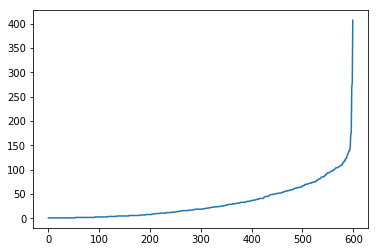

In [8]:
import collections
myCounter = collections.Counter(bestLabels.flatten())
plt.plot(sorted(myCounter.values()))

# Classification - SVM

## Spatial Histogram

In [17]:
bf = cv2.BFMatcher()

def getImageDescriptor(img, step=10, size=7):
    img = standarizeImage(img)
    cols, rows = img.shape[:2]
    
    # Extracting denseSIFT and BoW
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    matches = bf.knnMatch(des, vocab, k=1)
    words = [m[0].trainIdx for m in matches]
    
    # Spatial Binning - 2x2
    binX = 2; binY = 2;
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = int((k.pt[0]) * binX / cols)
        j = int((k.pt[1]) * binY / rows)
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] /= np.sum(temp[i, j, :])
    temp = temp.flatten()
    hist = temp
    
    # Spatial Binning - 4x4
    ################################
    # TODO : your code here
    #temp = None
    ################################
    hist = np.concatenate((hist, temp), axis=0)
    
    
    hist /= np.sum(hist)
    return hist    

## 1. Genarate spatial histogram for Training Images

In [18]:
# Extract spartial histogram for all training images
print('Extract spartial histogram for all training images')
BoW_train_ll = []
for c, image_list in zip(classes, train_image_ll):
    print(c, end=' '), 
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_train_ll.append(temp)

print('\ndone!')

Extract spartial histogram for all training images
Faces_easy camera grand_piano barrel mandolin yin_yang car_side garfield airplanes flamingo_head umbrella dolphin dragonfly inline_skate nautilus gerenuk crocodile Leopards gramophone headphone wild_cat dollar_bill laptop joshua_tree hedgehog rooster ibis electric_guitar platypus scorpion brain rhino hawksbill crab cannon beaver helicopter pyramid octopus revolver butterfly chair ceiling_fan wheelchair saxophone kangaroo lobster ewer buddha stapler panda water_lilly ant lotus okapi emu snoopy cup sunflower watch bass Faces brontosaurus starfish BACKGROUND_Google tick euphonium cellphone wrench scissors minaret crayfish soccer_ball anchor sea_horse trilobite cougar_body menorah flamingo Motorbikes elephant accordion pigeon llama binocular cougar_face dalmatian metronome pagoda mayfly stegosaurus chandelier windsor_chair ketch bonsai schooner ferry pizza lamp stop_sign strawberry crocodile_head 
done!


## 2. Train SVM

In [19]:
# Setting training data(BoW, label) for SVM
print('Setting training data(BoW, label) for SVM')
train_bow = []
train_labels = []
numSpartialHist = len(BoW_train_ll[0][0])
for i, BoW_list in enumerate(BoW_train_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        train_bow.append([temp])
    train_labels.extend([i] * len(BoW_list))
train_bow = np.concatenate(train_bow, axis=0)
train_labels = np.array(train_labels, dtype=np.int).reshape((numTrain*numClasses,1))
# => train_bow: (1530, 12000), train_labels: (1530,1)

print("train_bow: ", str(train_bow.shape))
print("train_labels: ", str(train_labels.shape))

Setting training data(BoW, label) for SVM
train_bow:  (1530, 4800)
train_labels:  (1530, 1)


In [20]:
# Train SVM
print('Training SVM...')
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(0.01)
svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 10, 1.0))

start_time = time.time()
# svm.train(SVM_train_data)
svm.train(train_bow, cv2.ml.ROW_SAMPLE, train_labels)
print('Elapsed time: {:6}s'.format(time.time() - start_time))

# print 'Saving SVM...'
# svm.save(svmPath)
print('Done!')

Training SVM...
Elapsed time: 10.033769130706787s
Done!


In [21]:
train_preds = svm.predict(train_bow)[1]
print('Training Accuracy: %.6f' % np.average(train_preds == train_labels))

Training Accuracy: 0.989542


## 3. Test trained SVM

In [22]:
# Extract spartial histogram for all test images
################################
# TODO : your code here
print('Extract spartial histogram for all test images\n')
BoW_test_ll = []

print('\ndone!')
################################

Extract spartial histogram for all test images


done!


In [23]:
# Setting test data(BoW, label) for SVM
print('Setting test data(BoW, label) for SVM')
################################
# TODO : your code here
test_bow = []
test_labels = []
numSpartialHist = len(BoW_test_ll[0][0])

# TODO : inference code here

test_bow = None
test_labels = None
print(test_bow.shape)
print(test_labels.shape)
################################

Setting test data(BoW, label) for SVM


IndexError: list index out of range

In [24]:
test_preds = svm.predict(test_bow)[1]
print('Test Accuracy: {:6}'.format(np.average(test_preds == test_labels)))

TypeError: samples is not a numpy array, neither a scalar

## 4. Sample Results

In [ ]:
# Show 8 random images
plt.figure(figsize=(16,10))
for i, r_c in enumerate(random.sample(range(len(classes)), 8)):
    # Random sample image from given class
    r_i = random.sample(range(numTest), 1)
    fpath = train_image_ll[r_c][r_i[0]]
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    
    # Get predicted label
    test_res = int(test_preds[r_c * numTest + r_i[0]][0])
    
    plt.subplot(2, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel("GT: {} / Predict: {}".format(classes[r_c], classes[test_res]))

# Practice: Classify your own image

Choose and classify your own test image using our classification.

- Place your image in the path where this notebook can access
- Load an image as grayscale
- Extract Dense SIFT BoW with `getImageDescriptor()`
- Normalize the bow with Hellinger's kernel
- Predict using the SVM classifier we have trained so far(`svm` instance)

In [ ]:
img_fpath = './images/dragonfly.jpg'  # Path to your own image
img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)

#================ YOUR CODE HERE ===================


prediction = 0  # Predicted class of your image
#===================================================

plt.imshow(cv2.cvtColor(cv2.imread(img_fpath), cv2.COLOR_BGR2RGB))
plt.xlabel("Prediction: {}".format(classes[prediction]))

In [ ]:
# Desired output